# Análise Exploratóra - PCA e Clustering

## Sobre este notebook

O objetivo deste notebook é identificar a distribuição das variáveis socioeconômicas dos municípios e agrupá-los em clusters a a partir de suas similaridades.

Utilizamos o PCA para reduzir a dimensionalidade do conjunto de dados e em seguida aplicamos o algoritmo K-Means para realizar o agrupamento. 

Pelo método do silhouette score, chegamos ao valor ótimo de k = 2. Utilizamos o algoritmo Boruta no dataset original para prever o valor dos clusters e selecionar o conjunto ótimo de features. Em seguida, rodamos o PCA no conjunto de dados com a melhores features e realizamos uma nova análise de clustering. A segunda análise indicou novamente um número ótimo de k = 2, porém com um silhouette score maior.

Após uma análise minunciosa, identificamos para o problema de negócio fazia mais sentido dividir os municípios em 4 clusters. Fizemos a seleção de um subconjunto de características de maior interesse e fizemos a comparação dos indicadores entre os clusters. Ao final o cluster de maior potencial foi escolhido

# 1) Imports

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")
sns.set_style("white")

# 2) Funções

In [82]:
def pca_plot(pca):
    variancia_explicada = pca.explained_variance_ratio_
    variancia_acumulada = np.cumsum(variancia_explicada)
    plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
    plt.xlabel('Número de Componentes Principais')
    plt.ylabel('Variância Explicada Acumulada')
    plt.title('Variância Explicada Acumulada por Componente Principal')
    plt.show()
    
def components(df_scaled):
    PCA_plot = PCA(n_components=2, random_state=42)
    df_components = PCA_plot.fit_transform(df_scaled)
    df_components = pd.DataFrame(df_components)
    df_components.columns = ['COMPONENT1', 'COMPONENT2']
    return df_components

def silhouette_plot(df_reducted):

    best_score = -1  
    best_n_clusters = 0  
    for n_clusters in range(2,10):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(df_reducted)
        score = silhouette_score(df_reducted, clusters)
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters

    silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
    plt.show()
    

def cluster_plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[
        [
            'NOME', 
            'COMPONENT1', 
            'COMPONENT2', 
            'CLUSTER'
        ]
    ].loc[
        df['NOME'].isin(
            [
                'MAURITI', 
                'SAO JOSE DA TAPERA', 
                'BUIQUE', 
                'INAJA'
            ]
        )
    ]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        hue='CLUSTER', 
        s=80,
    )
    sns.scatterplot(
        data=actual_cities, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        marker = 'X', 
        color='black', 
        s=100, 
        label='Cidades atuais'
    )
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] - 0.5, row['COMPONENT2'] + 0.5, row['NOME'], fontsize=10)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Grupos')
    sns.despine()
    plt.show()
    
def boruta(df, columns, k_clusters):
    X = df[columns]
    y = k_clusters

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
    boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
    boruta.fit(X_train.values, y_train)
    mask_columns_selected = boruta.support_.tolist()
    df_pp = X.iloc[:, mask_columns_selected]
    columns_selected = df_pp.columns
    return columns_selected

# 2) Coleta dos Dados

In [83]:
df = pd.read_csv(r'../Dados/Tabela_final/tabela_final.csv')

# 2) Análise Exploratória

## 2.1) Distribuição dos dados

Foi realizada uma breve análise da distribuição dos dados a fim de identificar possíveis inconsistência e outliers.

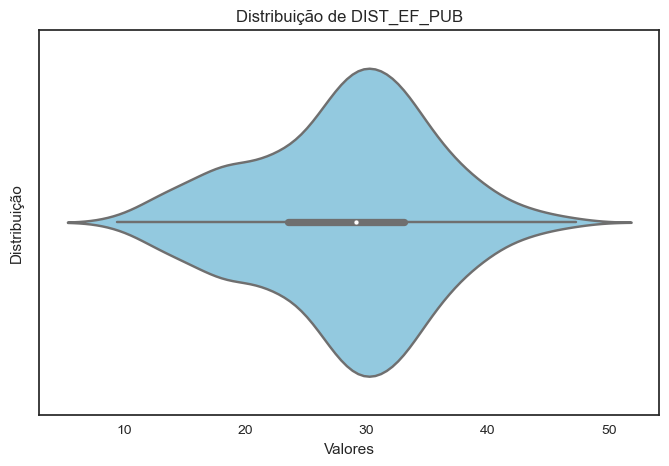

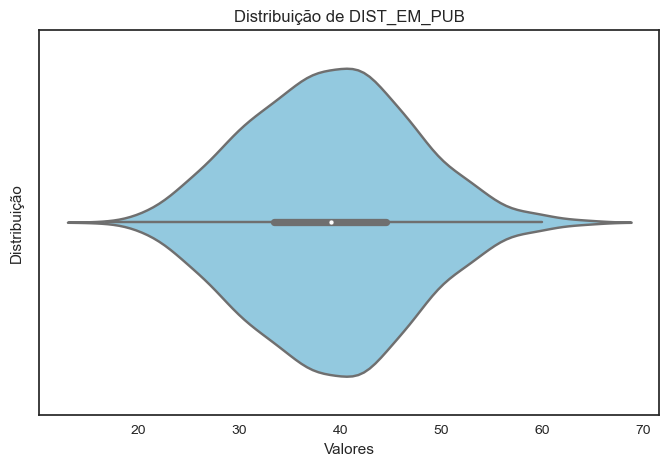

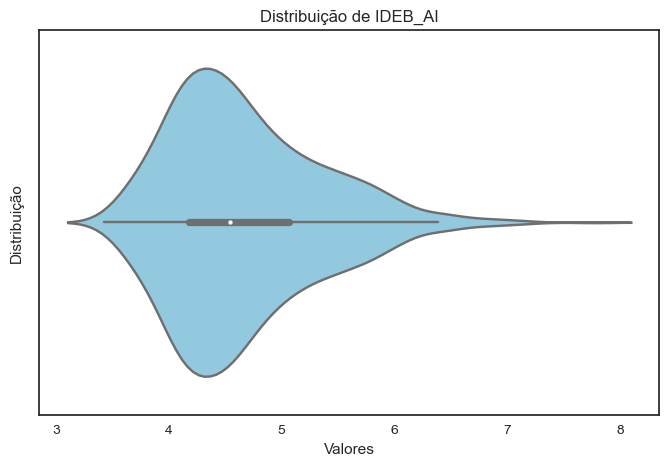

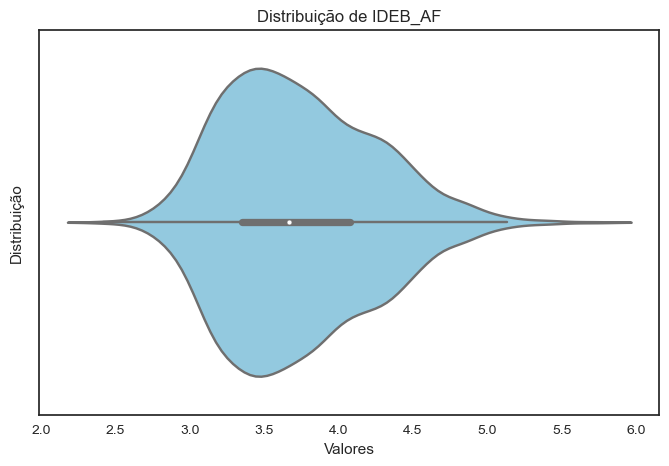

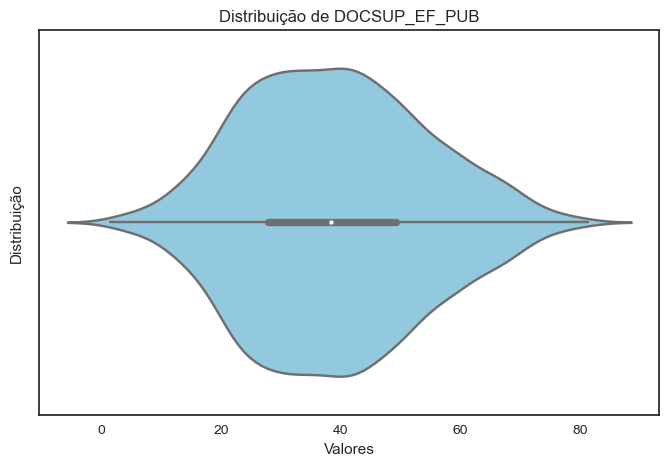

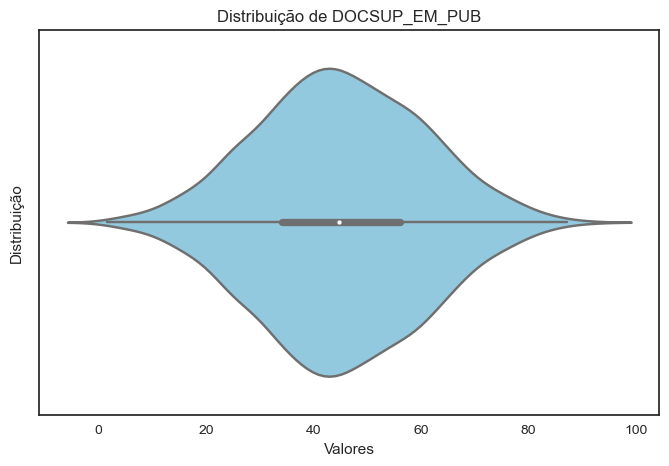

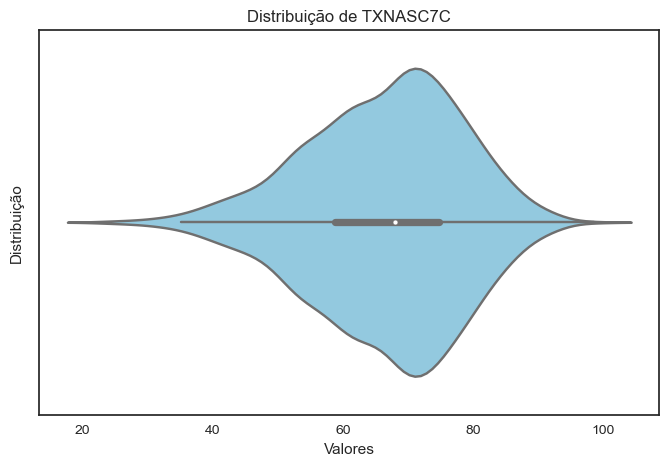

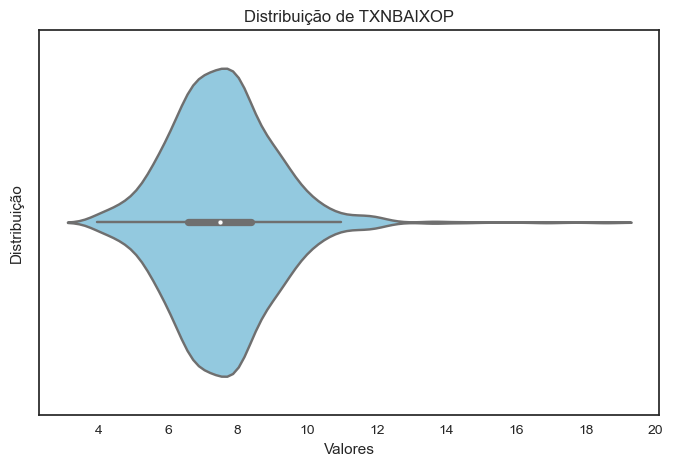

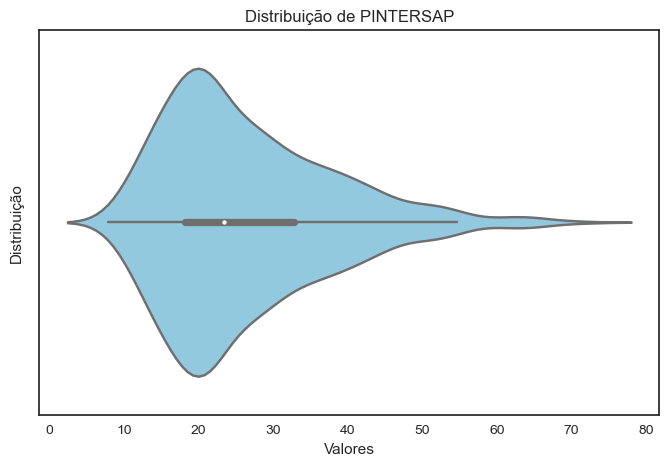

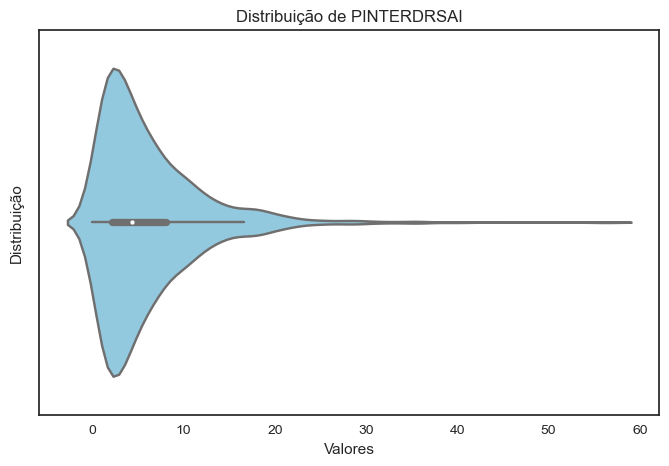

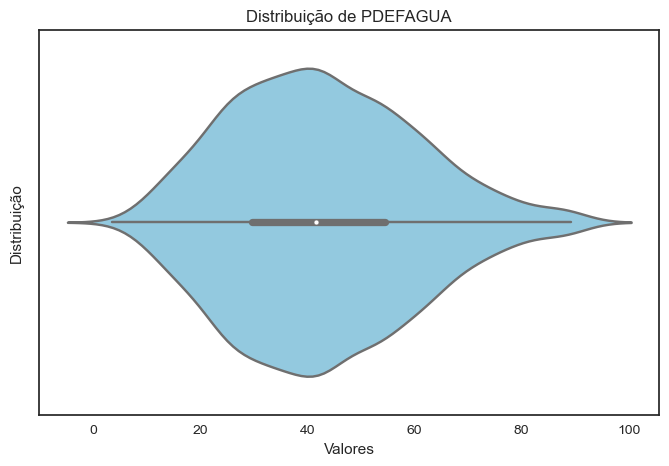

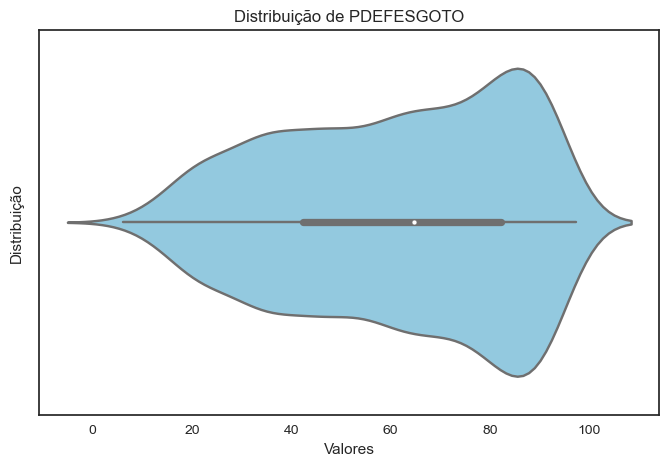

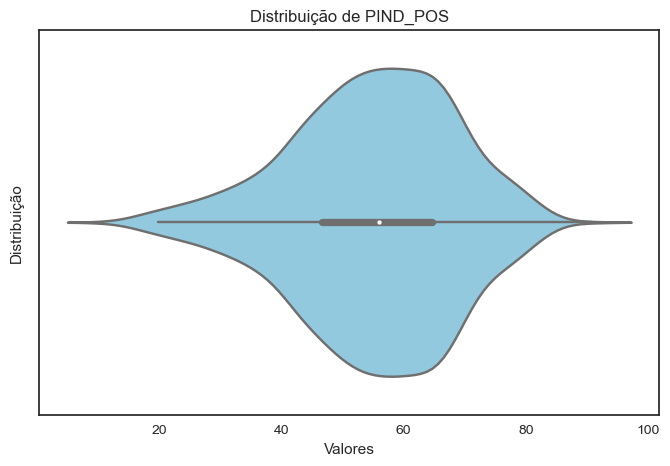

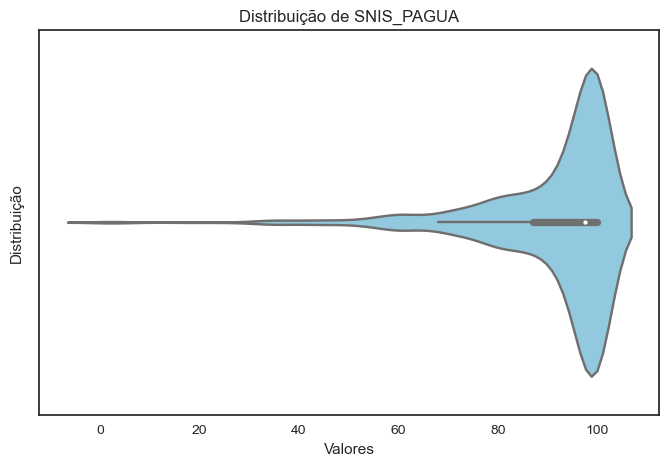

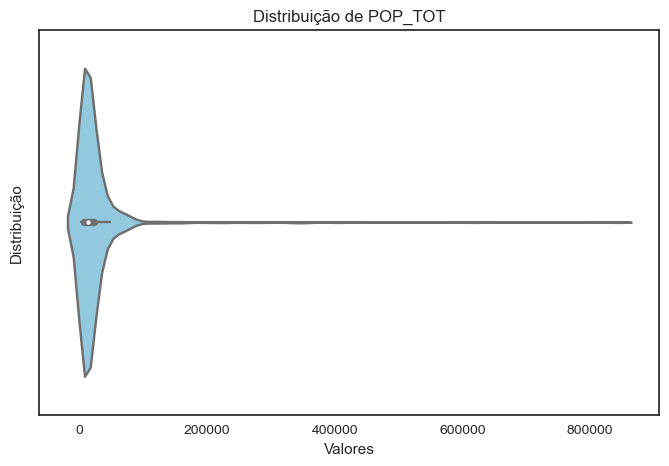

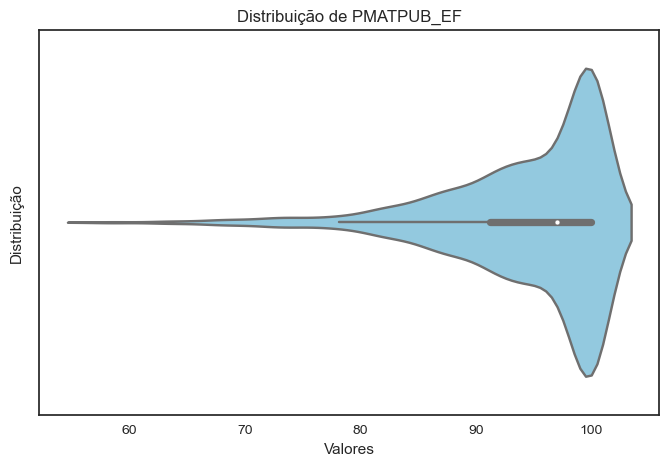

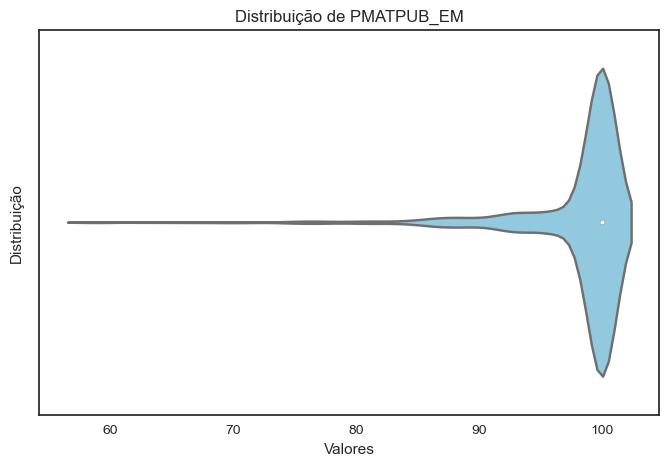

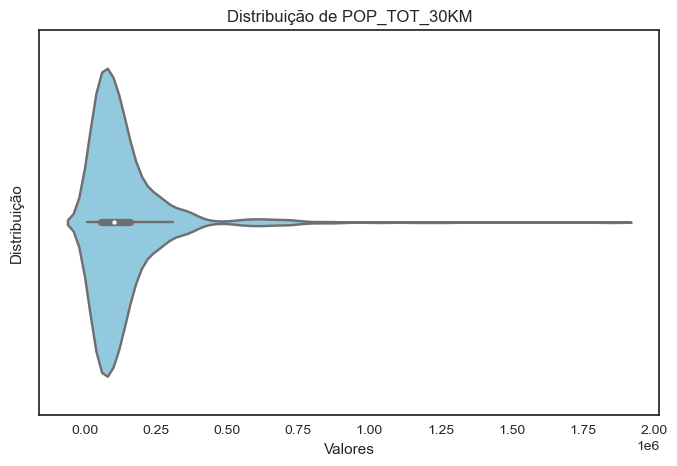

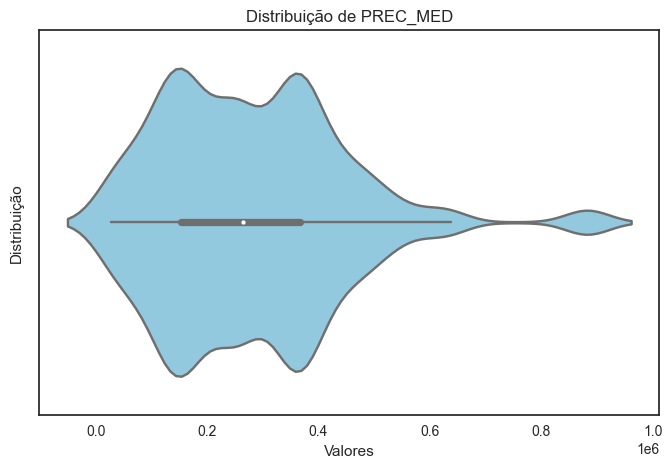

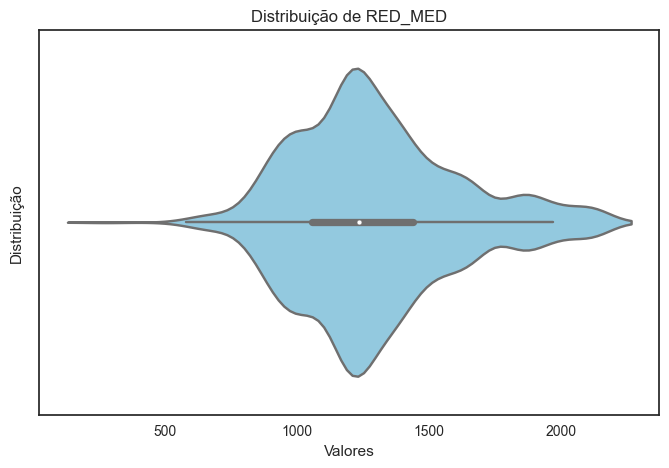

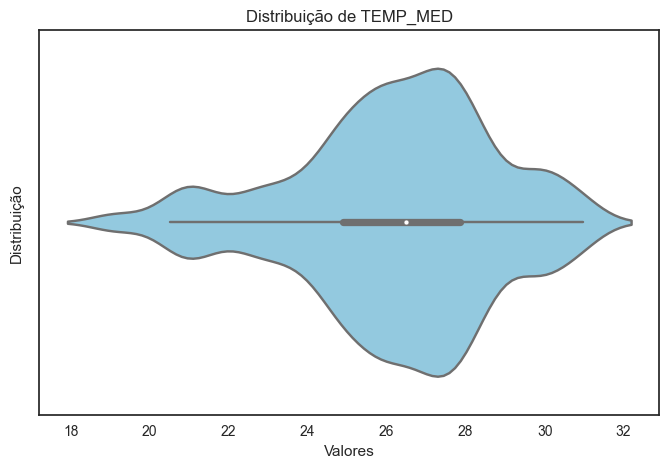

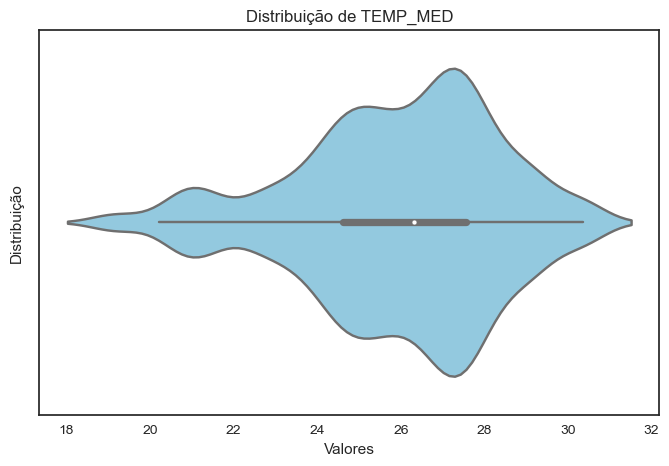

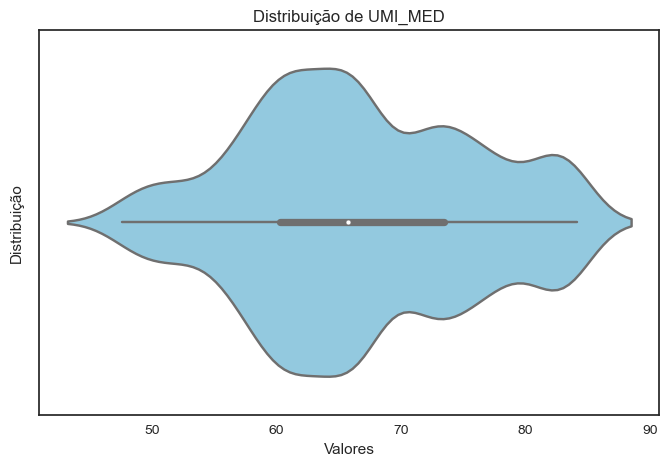

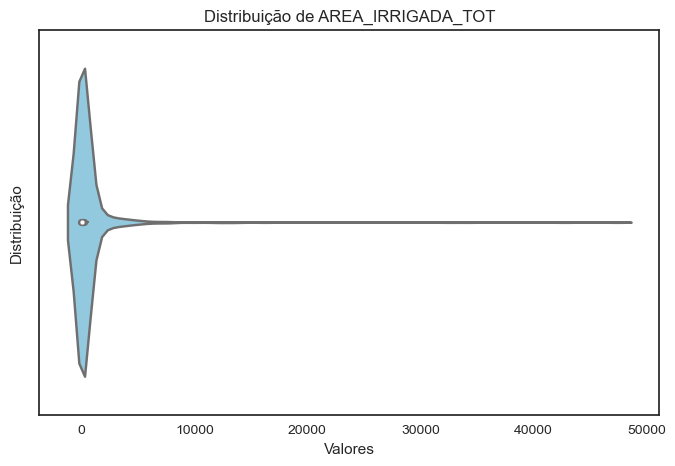

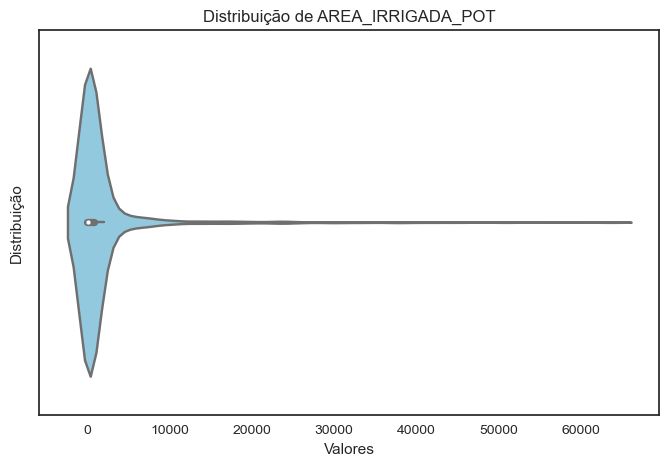

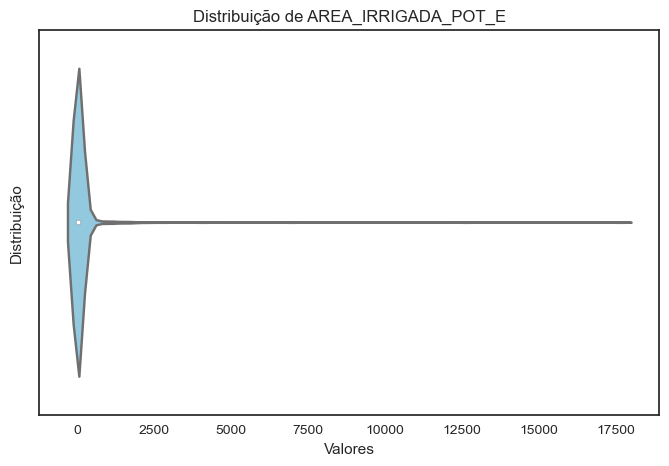

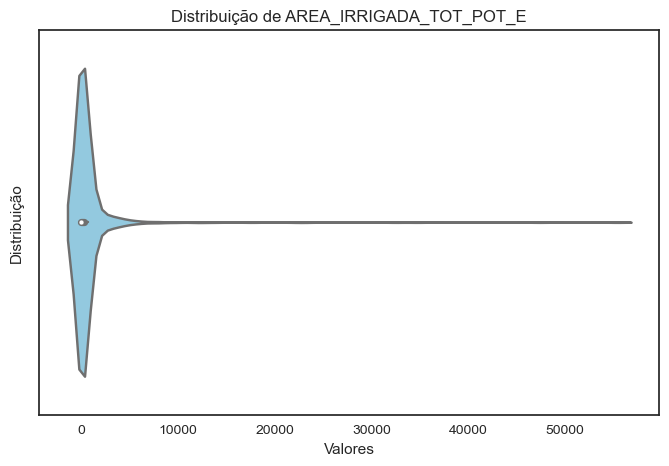

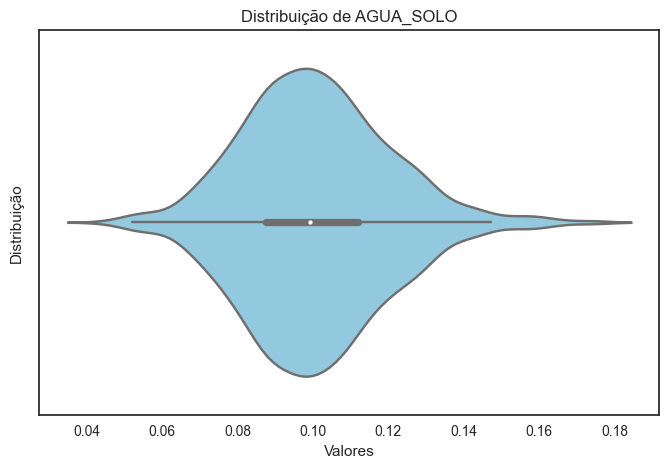

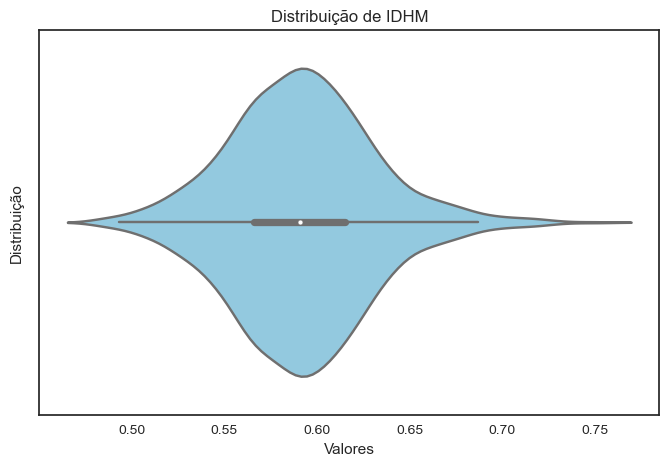

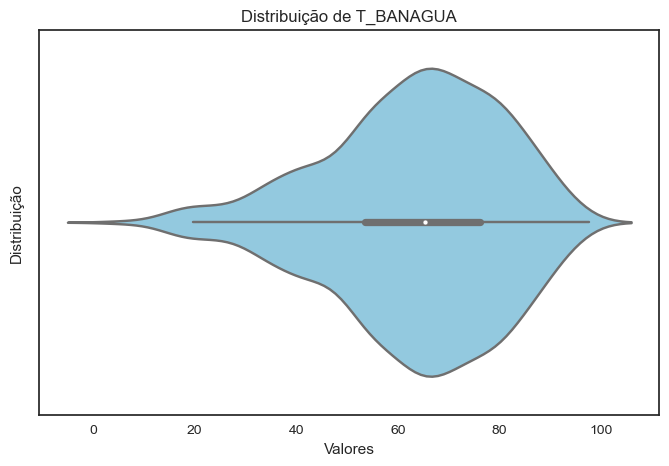

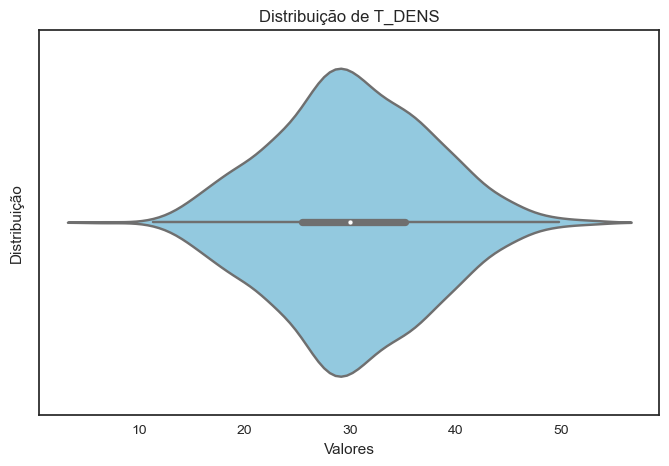

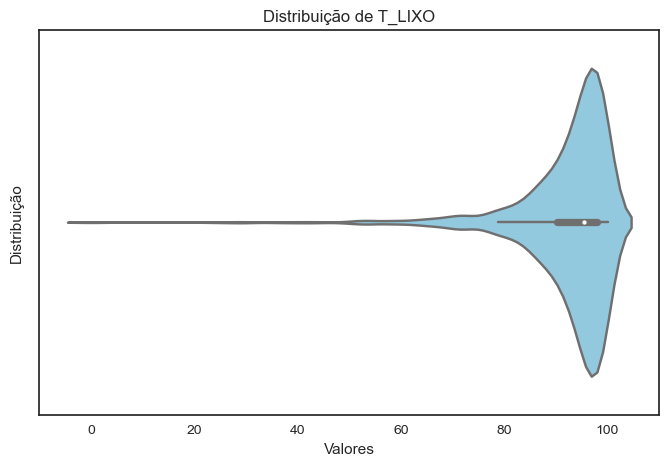

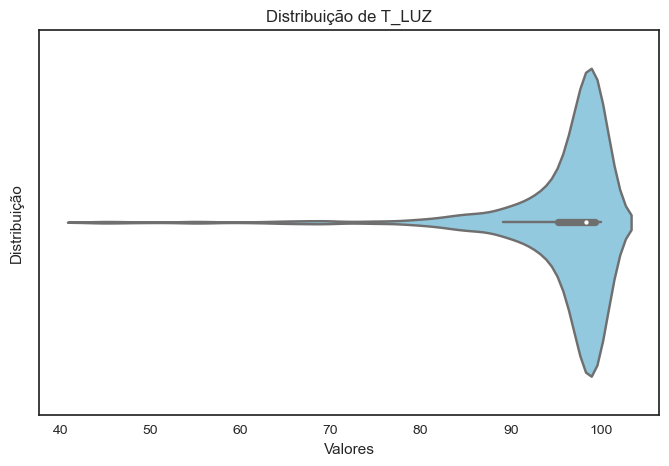

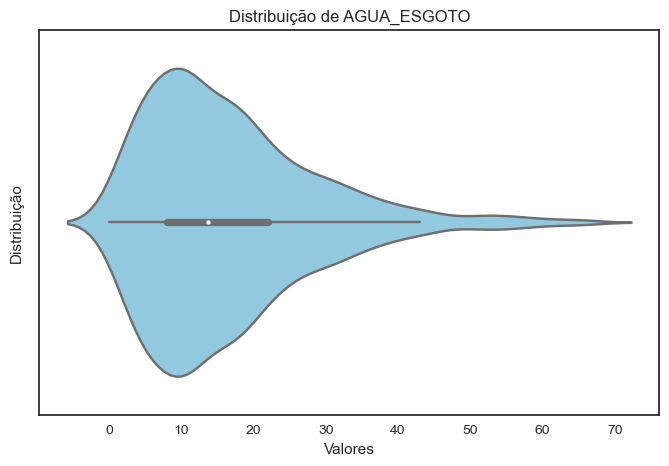

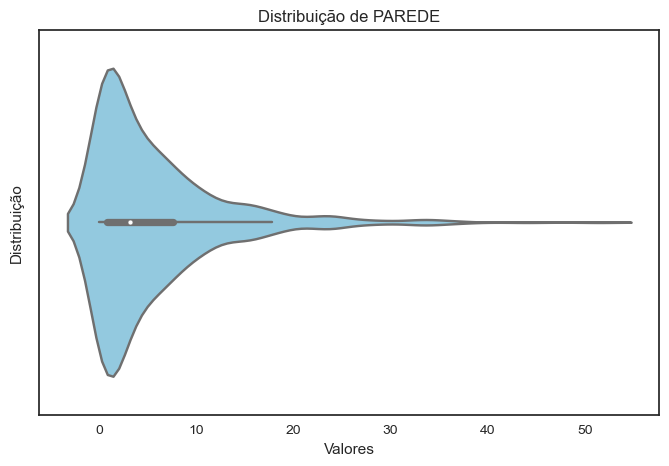

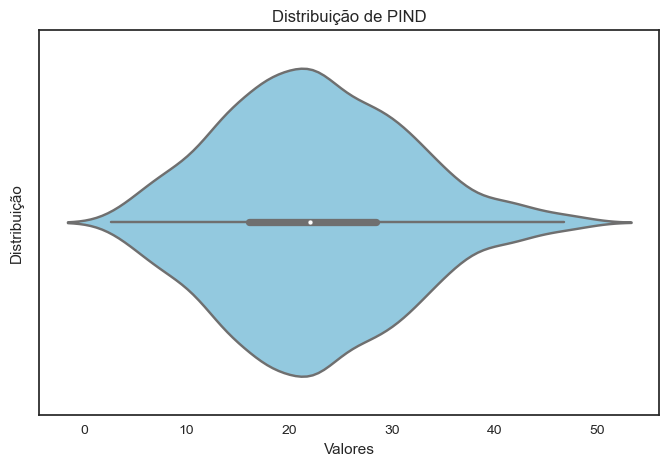

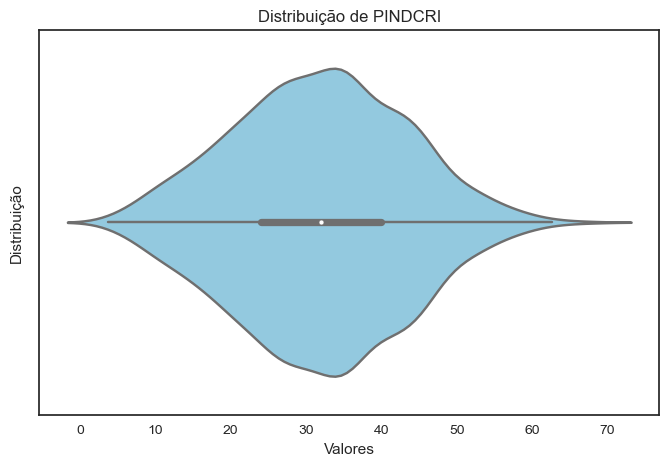

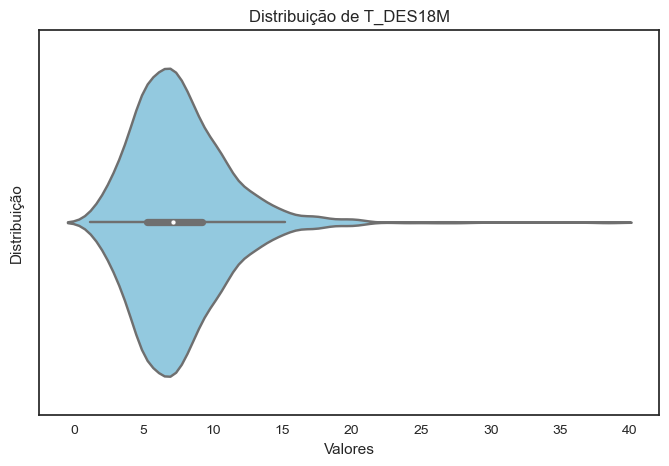

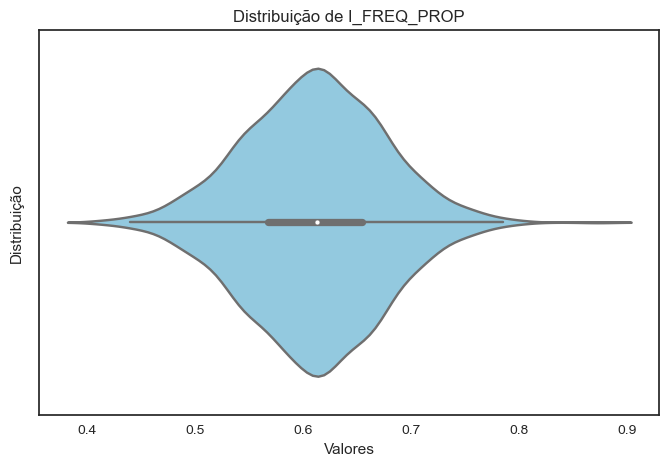

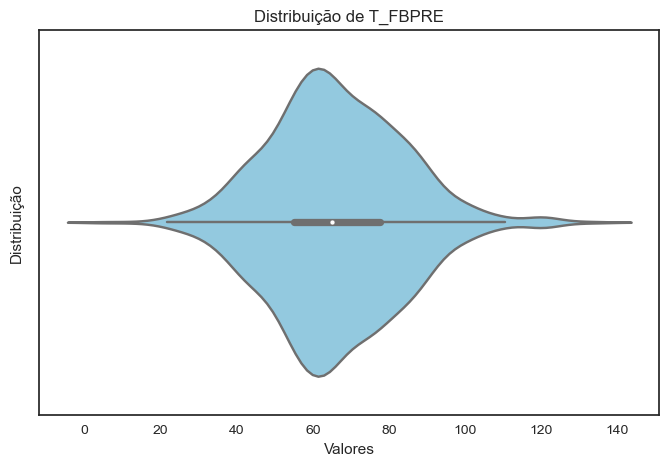

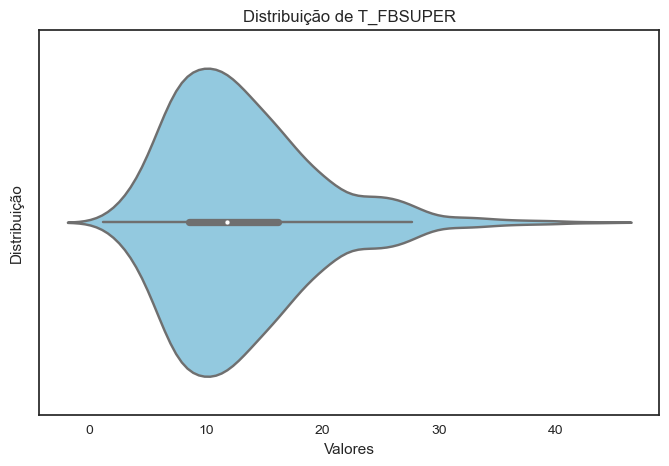

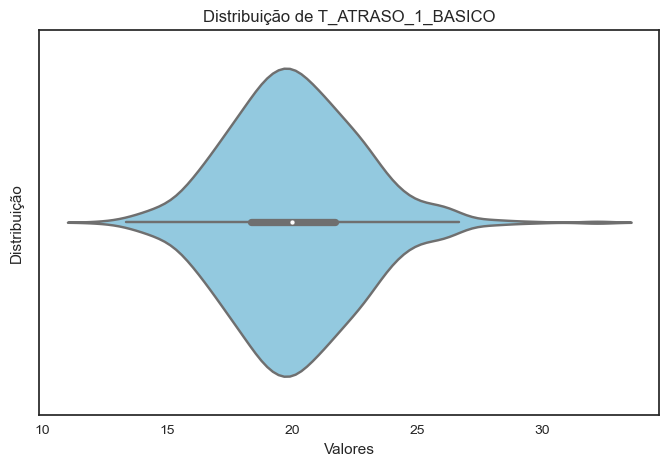

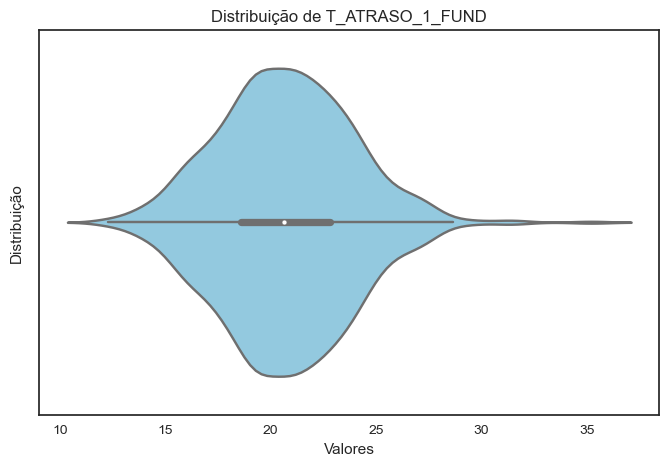

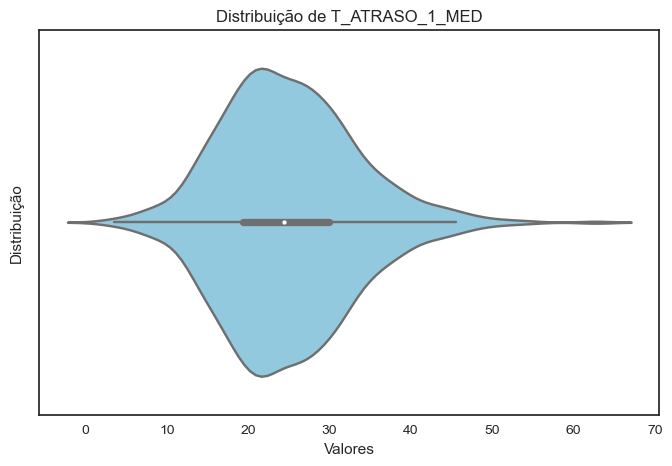

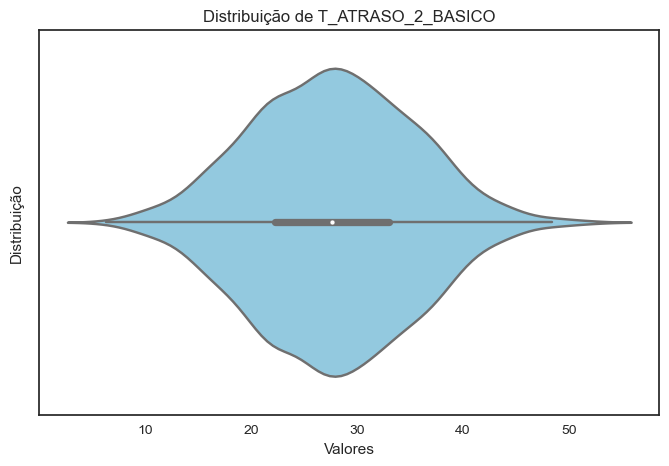

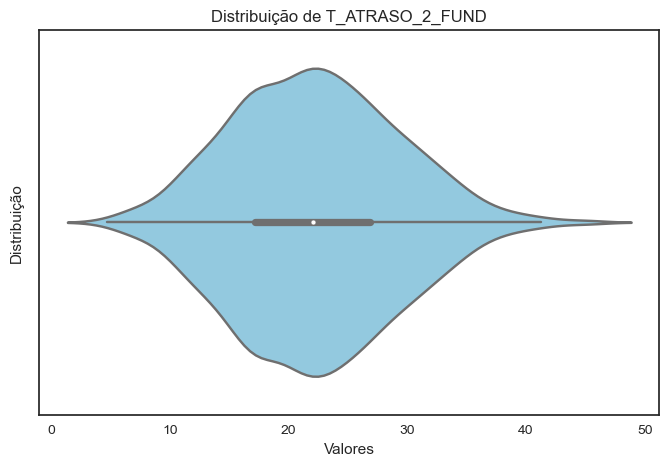

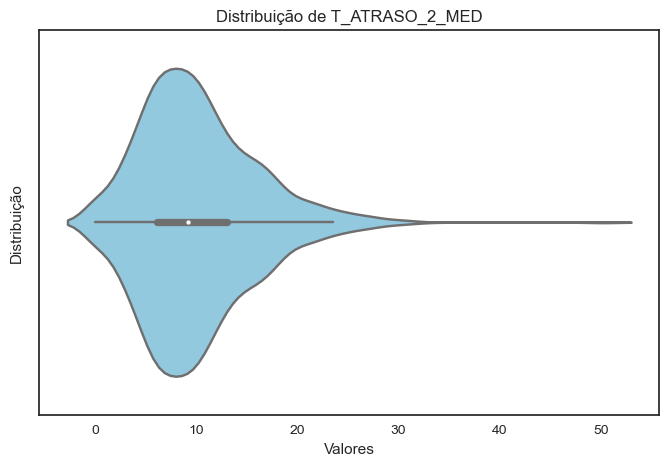

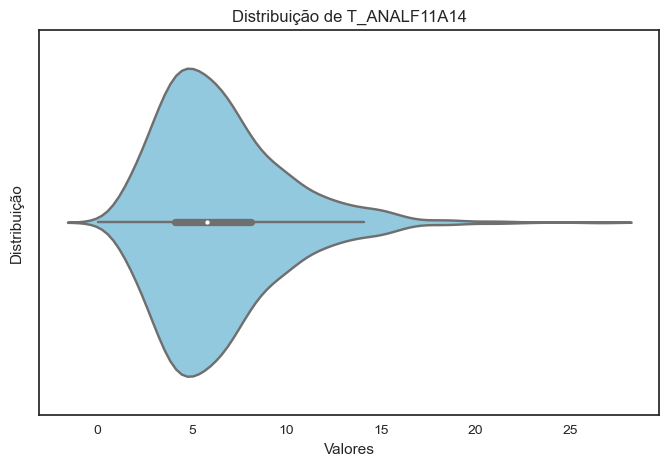

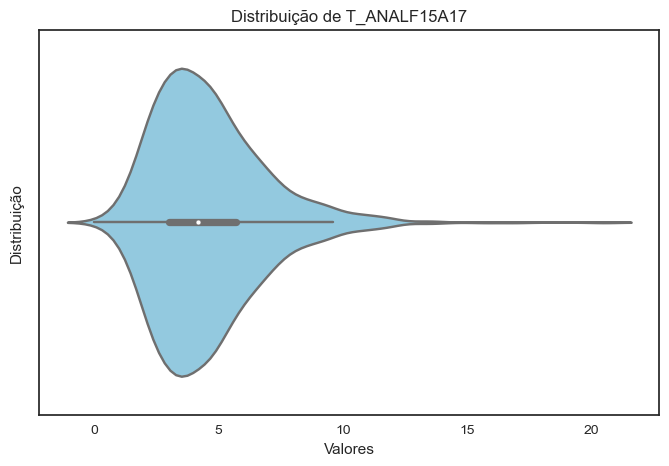

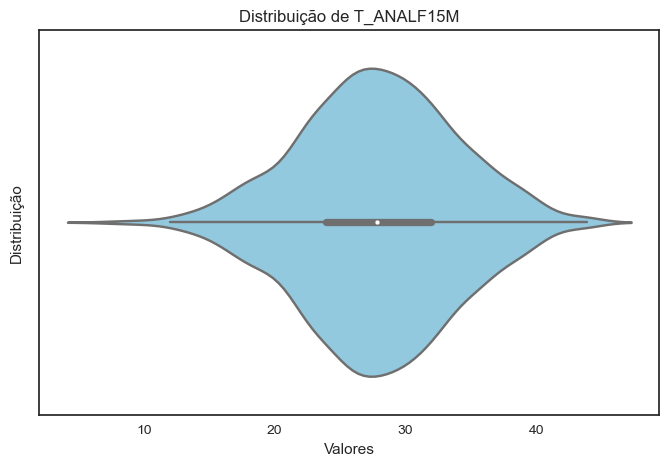

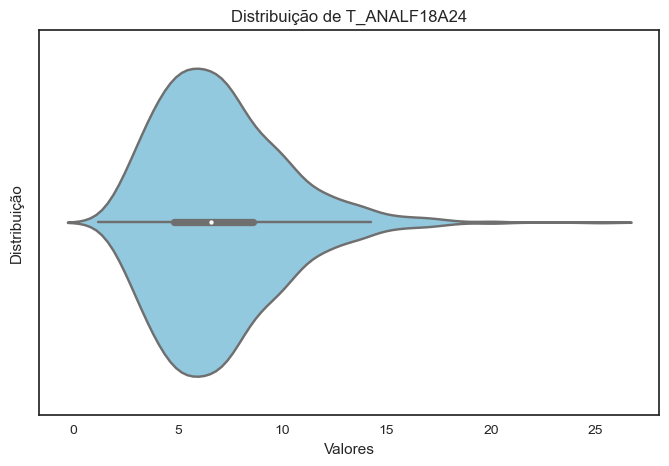

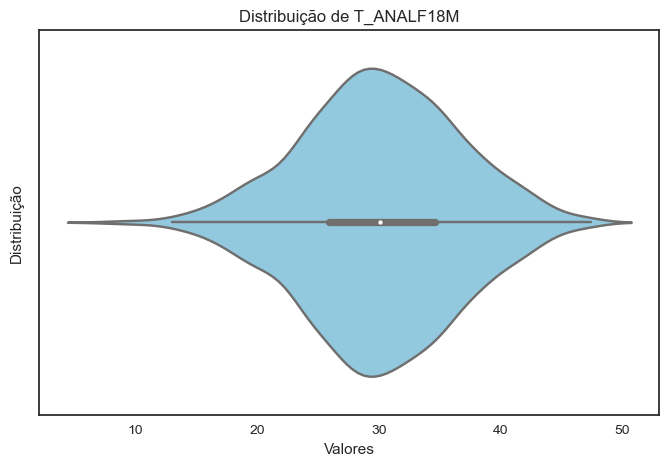

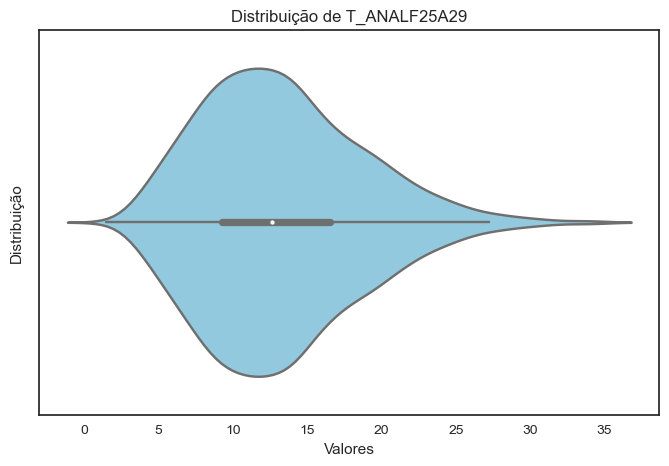

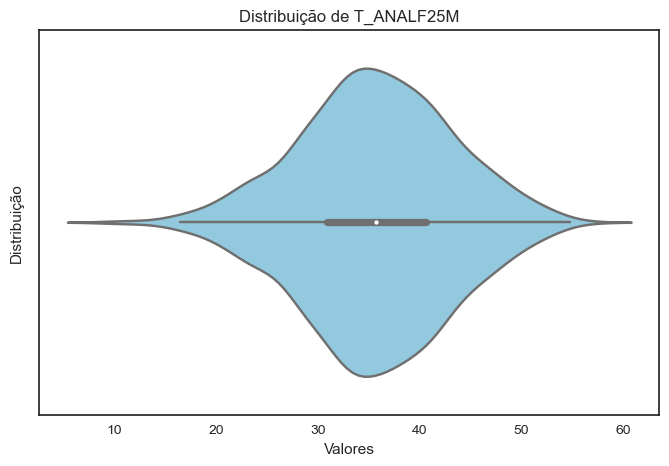

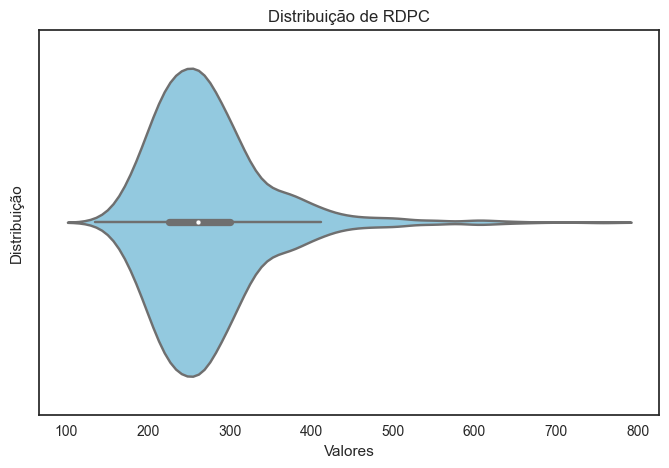

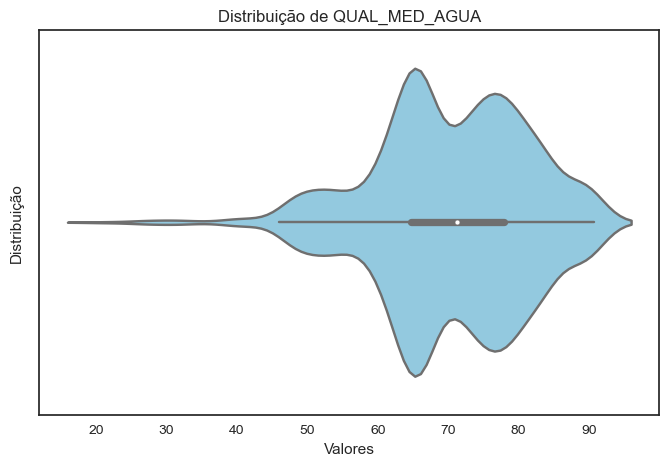

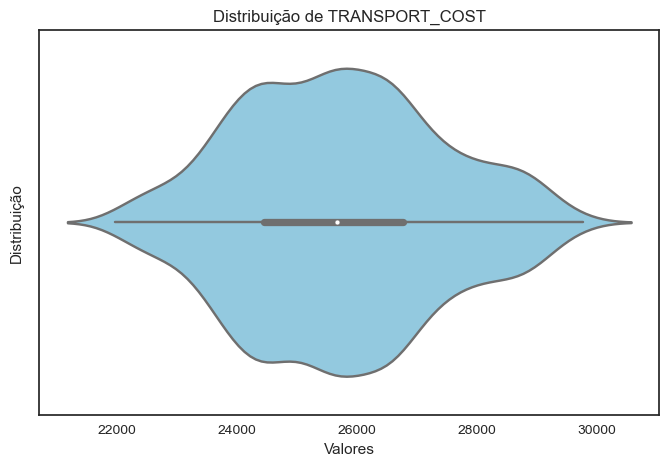

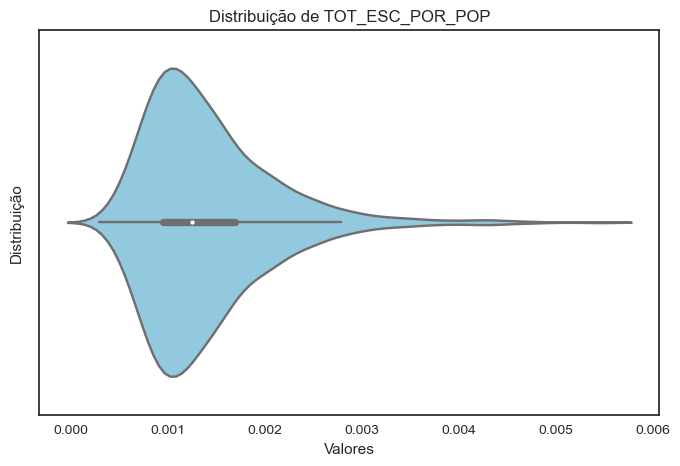

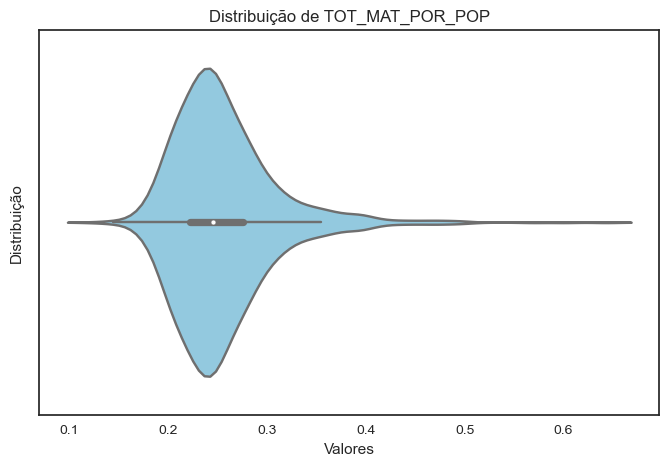

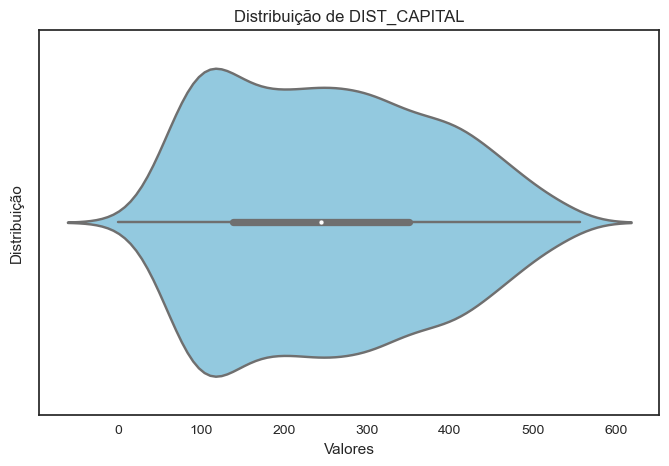

In [84]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

for column in columns:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[column], color='skyblue')
        
    plt.xlabel('Valores') 
    plt.ylabel('Distribuição')
    plt.title(f'Distribuição de {column}')
    plt.show()

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

O StandardScaler foi utilizado para escalonar os dados e permitir seu processamento pelo PCA

In [85]:
df_numeric_features = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_features)

## 3.2) Aplicação do PCA

Para garantir que o conjunto de dados transformado não apresentasse ruídos, foi selecionado um threshold de 0.5 para manter 50% da variância. Como resultado, o PCA retornou 6 componentes principais.

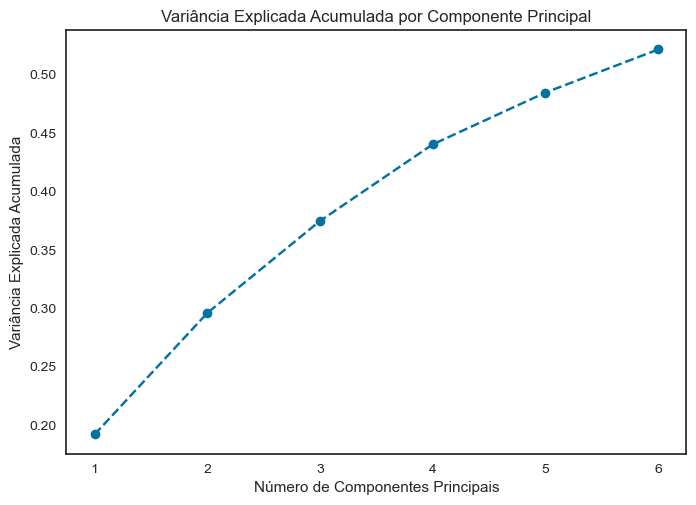

In [86]:
pca = PCA(n_components = 0.50)
df_reducted = pca.fit_transform(df_scaled)
pca_plot(pca)

## 3.3) Análise de cluster

Foi criada uma função para realizar a visualização dos clusters nos dois componentes principais do PCA

In [87]:
df_components = components(df_scaled)

### 3.3.2) K-Means

Através do método do silhouette score, foi definido que o número de ótimo de clusters é igual a 2. Com isso, foi criada um modelo para dividir os municipios em dois grupos principais.

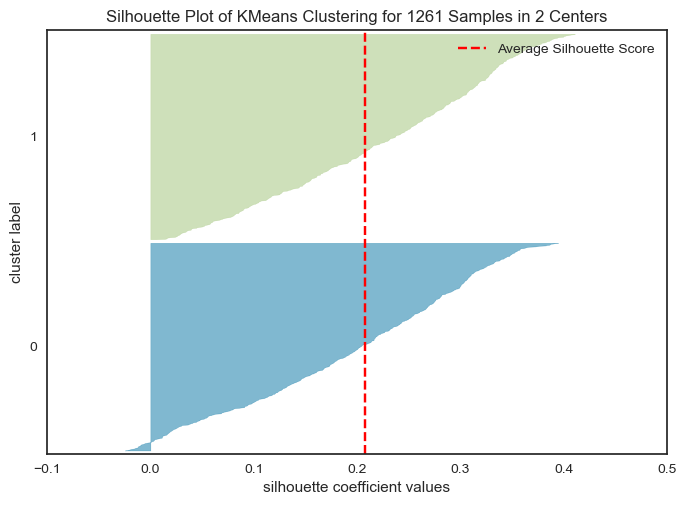

In [88]:
silhouette_plot(df_reducted)

Silhouette Score:  0.2077
Davies-Bouldin Score:  1.6986
Calinski-Harabasz Index:  375.9995


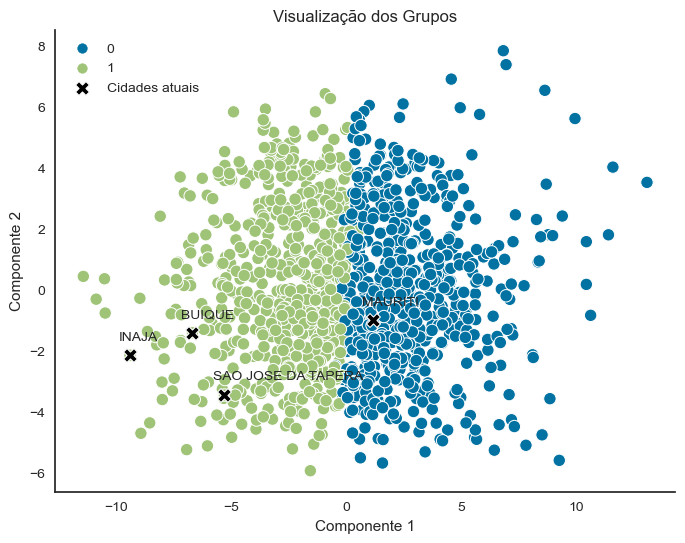

In [89]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
cluster_plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

O algoritmo Boruta foi utilizado para selecionar o subconjunto ideal de features para a clusterização. Foi adicionado um vetor com os valores dos clusters de cada município e em seguida o Boruta utilizou o Random Forest para selecionar os melhores features para prever o o valor dos clusters. Um ponto interessante em relação a saída do algoritmo é participação níval de variáveis de educação.

In [90]:
columns_selected = boruta(df, columns, k_clusters)
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'PDEFAGUA', 'PDEFESGOTO', 'PIND_POS',
       'PMATPUB_EF', 'AGUA_SOLO', 'IDHM', 'T_BANAGUA', 'T_DENS', 'T_LUZ',
       'AGUA_ESGOTO', 'PIND', 'PINDCRI', 'I_FREQ_PROP', 'T_FBSUPER',
       'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED',
       'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED',
       'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24',
       'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'RDPC', 'TOT_ESC_POR_POP'],
      dtype='object')

## 3.5) Pré-processamento

Foi gerado um novo dataframe a partir do inicial com o subconjunto ideal de features retornadas pelo Boruta e, em seguida, foi realizado novamente o pré-processamento adequado para os dados serem lidos pelo PCA.

In [91]:
df_best_features = df[columns_selected].copy()
df_scaled = scaler.fit_transform(df_best_features)

## 3.6) Nova aplicação do PCA

O novo PCA aplicado no dataframe com as features selecionadas retornou 3 componentes principais preservando 50% da variância.

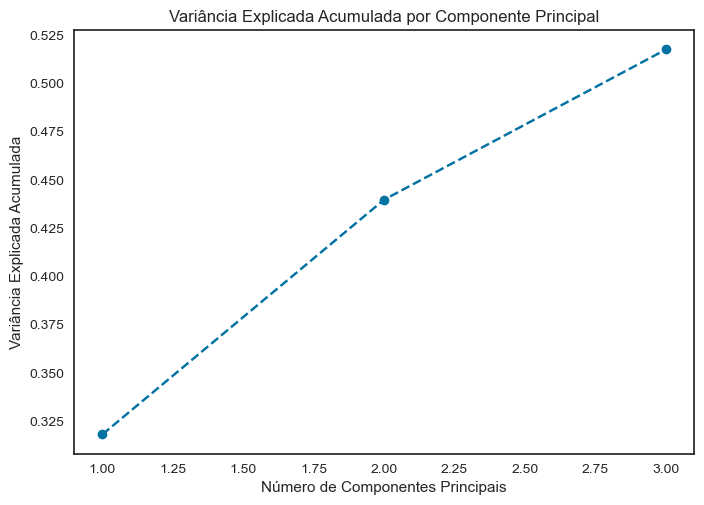

In [92]:
df_reducted = pca.fit_transform(df_scaled)
pca_plot(pca)

## 3.6) Nova análise de cluster

In [93]:
df_components = components(df_scaled)

### 3.6.2) K-Means

Em seguida, foi realizada uma nova análise de clustering. O método do silhouette score retornou novamente o valor ótimo de k = 2 clusters. Após o boruta, as métricas de avaliação das clusterização melhoraram consideravelmente.

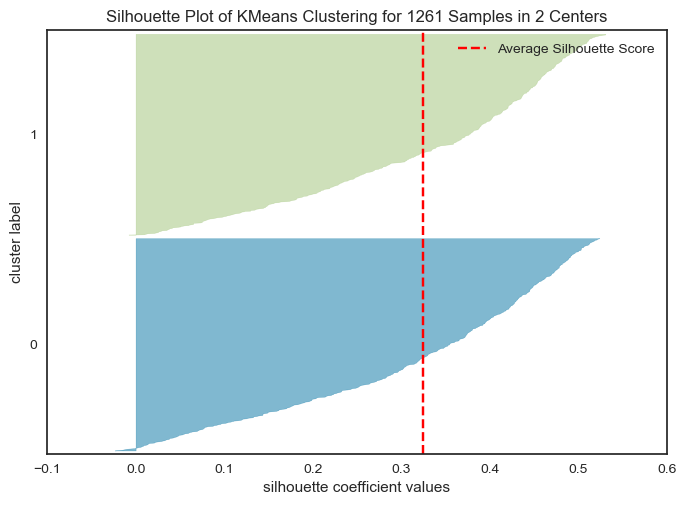

In [94]:
silhouette_plot(df_reducted)

Silhouette Score:  0.3247
Davies-Bouldin Score:  1.1458
Calinski-Harabasz Index:  797.0928


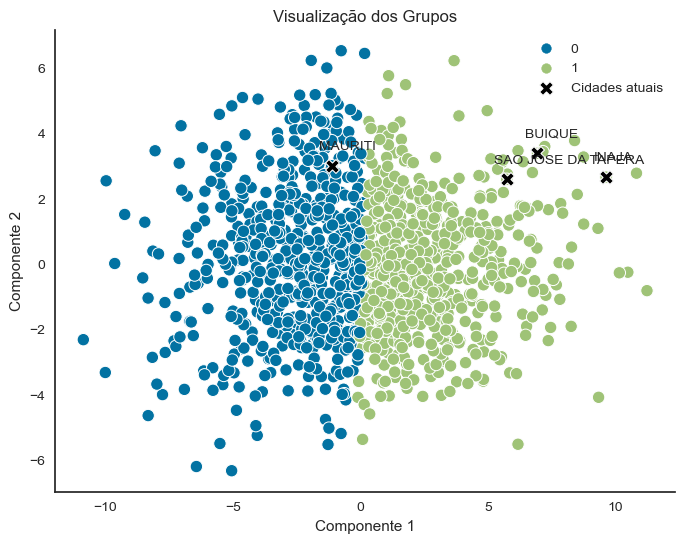

In [95]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
cluster_plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

Através das nossas análises, identificamos que, apesar de dividir melhor os dados, o valor de k = 2 dificulta a interpretação dos resultados por concentrar um número grande de cidades em cada grupo. Logo, foi selecionado o valor de **k = 4** para que os municípios possam ser investigados de maneira mais segmentada.

Silhouette Score:  0.256
Davies-Bouldin Score:  1.1762
Calinski-Harabasz Index:  599.9164


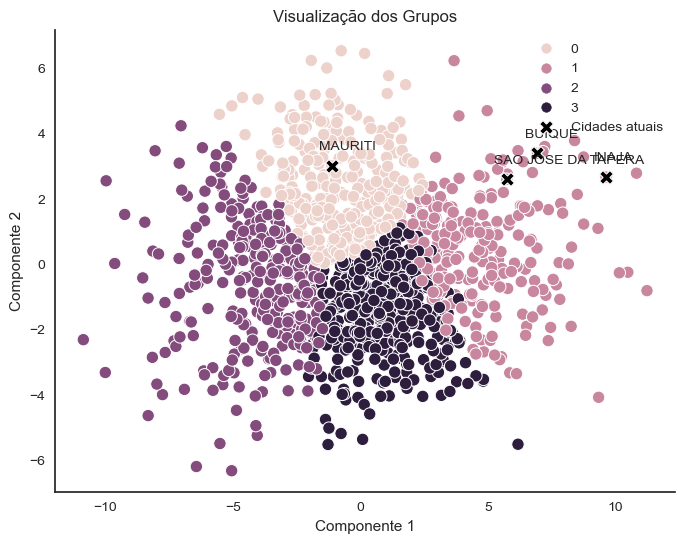

In [96]:
kmeans = KMeans(4, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
cluster_plot(df, df_components, k_clusters)

In [97]:
df['CLUSTER'] = k_clusters
df.to_csv('../Dados/Tabela_final/municipios_clusters.csv')

### 3.4.1) Interpretação dos municípios atuais

Dado que o objetivo da ONG Amigos do Bem é impactar pessoas, decidimos filtrar os municípios cuja população total e população em um raio de 30 km fossem inferiores aos menores valores dos municípios que a ONG atua no presente.

In [98]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,188.84,37.04,0.536,4.33,39.70,1
418,MAURITI,0.605,46103.4,207315.4,236.11,29.51,0.632,8.31,29.78,3
796,BUIQUE,0.527,56502.4,234399.4,176.76,40.18,0.524,7.25,38.73,1
827,INAJA,0.523,21917.0,89734.8,182.73,35.98,0.471,7.35,41.19,1


In [99]:
df = pd.read_csv('../Dados/Tabela_final/municipios_clusters.csv')
df = df.loc[(df['POP_TOT'] >= 21917)&(df['POP_TOT_30KM'] >= 89734)]

### 3.4.1) Filtro e interpretação dos clusters

Utilizando como base materiais disponibilizados publicamente pela ONG Amigos do Bem em seus canais de comunicação, realizamos a seleção de um subconjunto de métricas que oferecem uma melhor visão acerca da situação socioeconômica dos municípios. 

In [100]:
df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
CLUSTER,,,,,,,,
0,0.658235,97560.827451,313377.531373,417.452451,19.411961,0.663549,8.329314,10.883431
1,0.548475,35384.045000,197770.365000,229.427250,33.828750,0.529675,6.538000,30.923250
2,0.595426,40248.180328,193307.622951,302.511803,25.591803,0.584230,8.318361,18.969180
3,0.605278,40698.314815,207237.329630,253.462222,28.825000,0.659111,6.761481,25.466852


In [101]:
df['CLUSTER'].value_counts()

CLUSTER
0    102
2     61
3     54
1     40
Name: count, dtype: int64

### 3.4.1) Seleção dos municipios de maior potencial

Ao comparar a médias dos municípios de cada cluster, identificamos que os municípios do **cluster 1** são os que apresentam maior defasagem. Logo, estes foram selecionados para se tornarem o foco da nosso processo investigativo.

In [102]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'IDEB_AI',
        'IDEB_AF',
        'POP_TOT_30KM',
        'POP_TOT'
    ]
].loc[
    (potential_muns['CLUSTER'] == 1)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,POP_TOT_30KM,POP_TOT
0,2916500,ITAPICURU,BA,0.486,6362.64,38.52,0.462,9.86,31.44,3.912,2.784,197766.2,35881.0
1,2705002,MATA GRANDE,AL,0.504,3566.69,38.79,0.499,1.57,41.39,4.152,3.260,129923.6,25555.2
2,2921500,MONTE SANTO,BA,0.506,3520.33,35.57,0.494,4.55,35.11,3.796,3.036,107356.8,53678.4
3,2607505,ITAIBA,PE,0.510,5217.68,39.73,0.497,4.11,27.48,4.104,3.268,129160.2,26440.2
4,2615805,TUPANATINGA,PE,0.519,4048.49,38.41,0.513,5.31,45.08,5.200,3.564,135832.6,26445.0
5,2100907,ARAIOSES,MA,0.521,3338.50,33.70,0.530,7.70,40.55,3.892,3.292,278943.2,45225.2
6,2603207,CAETES,PE,0.522,3518.20,38.63,0.530,3.82,42.77,4.584,3.660,275058.0,28139.2
7,2702355,CRAIBAS,AL,0.525,4664.40,39.67,0.554,2.73,30.89,4.000,2.916,452771.8,24250.4
8,2600500,AGUAS BELAS,PE,0.526,4210.35,40.23,0.484,6.76,31.96,4.356,3.904,120915.8,42556.6
9,2805406,POCO REDONDO,SE,0.529,4873.91,35.58,0.489,6.55,36.41,3.640,3.176,160430.8,33748.0
